In [1]:
%display latex
qf = qepcad_formula
import numpy as np

# Lotka-Volterra with role reversal

In [2]:
R.<x,y> = QQ[]
us = [x,y]
k=QQ(0.8); b=QQ(0.6); c=QQ(0.3); e=QQ(0.05); f=QQ(2)
vf = vector([b*x*(QQ(1)-x) - c*x*(k-x)*y,
            -e*y*(QQ(1)+y)+f*x*(k-x)*y])
v0 = [2.0, 1.0]

In [3]:
#ode = [diff(u,t) == v for u,v in zip(us,vf)]; ode

In [4]:
vf

(3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y)

## Sample trajectory

In [5]:
ts = srange(0,50,0.5)
sol = desolve_odeint(vf, v0, ts, us,compute_jac=True)

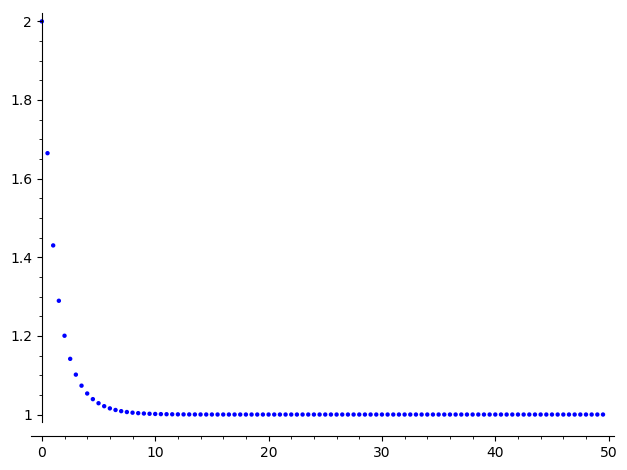

In [6]:
p = points(zip(ts,sol[:,0]))
p.show()

## Phase portrait 

In [7]:
plot_vector_field((SR^2)(vf)/(SR^2)(vf).norm(),(x,0,1.5),(y,0,8))

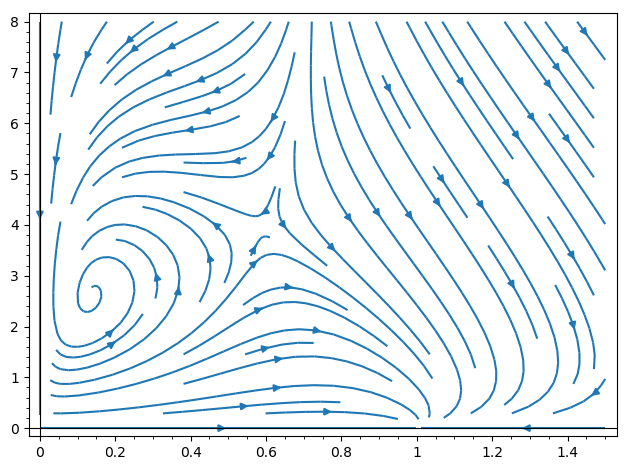

In [8]:
streamline_plot(tuple(vf),(x,0,1.5),(y,0,8))

## Nullclines

In [9]:
factsx,factsy = [[a for a,_ in v.factor() if a.variables()] for v in vf]
factsx,factsy

([x, 5*x*y - 10*x - 4*y + 10], [y, 40*x^2 - 32*x + y + 1])

In [10]:
equillib = [(d[SR(x)], d[SR(y)]) for d in
            solve([SR(v) == 0 for v in vf],map(SR,us),solution_dict=True)
            if d[SR(x)] >= 0 and d[SR(y)] >= 0]
equillib

[(0, 0),
 (1, 0),
 (0.1355180875484841, 2.601972729910067),
 (0.5920959774170783, 3.923965351299326)]

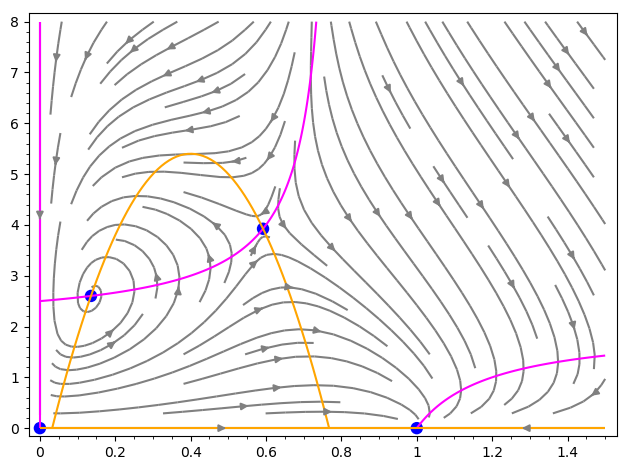

In [11]:
p = []
p.append(streamline_plot(tuple(vf),(x,0,1.5),(y,0,8),color="grey"))
p.append(implicit_plot(factsx[0], (x,0,1.5), (y,0,8),
                       aspect_ratio='automatic',color="magenta"))
p.append(implicit_plot(factsx[1], (x,0,1.5), (y,0,8),
                       aspect_ratio='automatic',color="magenta"))
p.append(implicit_plot(factsy[0], (x,0,1.5), (y,0,8),
                       aspect_ratio='automatic',color="orange"))
p.append(implicit_plot(factsy[1], (x,0,1.5), (y,0,8),
                       aspect_ratio='automatic',color="orange"))
p.append(points(equillib,color="blue",size=80))
sum(p)

## Lie derivative computation

In [12]:
def lie(f,p,n=1):
    if n == 0:
        return p
    elif n > 0:
        return lie(f, vector(p.gradient()[-len(f):])*f, n - 1)
    else:
        raise Exception()

### Plot of Lie derivatives

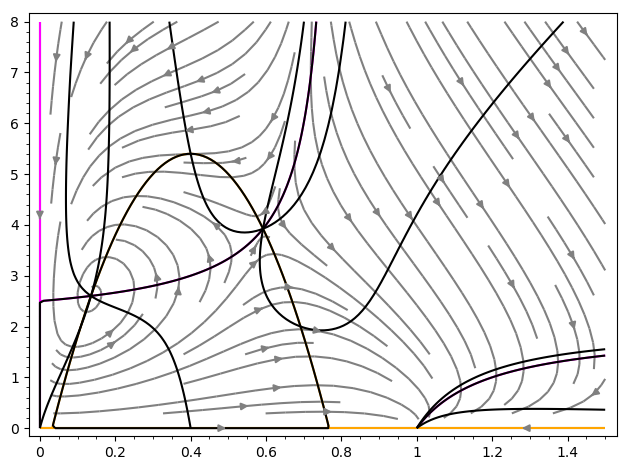

In [13]:
p = []
p.append(streamline_plot(tuple(vf),(x,0,1.5),(y,0,8),color="grey"))
p.append(implicit_plot(factsx[0], (x,0,1.5), (y,0,8),
                       aspect_ratio='automatic',color="magenta"))
p.append(implicit_plot(factsx[1], (x,0,1.5), (y,0,8),
                       aspect_ratio='automatic',color="magenta"))
p.append(implicit_plot(factsy[0], (x,0,1.5), (y,0,8),
                       aspect_ratio='automatic',color="orange"))
p.append(implicit_plot(factsy[1], (x,0,1.5), (y,0,8),
                       aspect_ratio='automatic',color="orange"))
for g in factsx + factsy:
    c = SR(lie(vf,g)) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color="black"))
sum(p)

### Plot of higher Lie derivatives

In [14]:
p = []
p.append(streamline_plot(tuple(vf),(x,0,1.5),(y,0,8),color="grey"))
for g in factsx + factsy:
    for n in range(3):
        c = SR(lie(vf,g,n)) == 0
        col = ["red","blue","black"][n]
        p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                               aspect_ratio='automatic',color=col))
sum(p)

## $\mathrm{DRI}$ decision procedure

In [15]:
def dri(f,p,N):
    '''Given a vector field f and a scalar field p, try to prove p is
    invarient under f, in at most N steps of the DRI rule. If successful,
    return the n required, otherwise, return False.'''
    L = []
    for n in range(0,N+1):
        d = lie(f,d) if n > 0 else p
        if d in R.ideal(L):
            return n
        L.append(d)
    return False

In [16]:
from subprocess import call
from contextlib import contextmanager

TimeoutError = KeyboardInterrupt

@contextmanager
def timeout(seconds=1, g = None):
    try:
        alarm(seconds)
        yield
        cancel_alarm()
    except TimeoutError:
        if g is None:
            raise
        else:
            g()

In [17]:
from sage.interfaces.quit import expect_quitall, kill_spawned_jobs

def qcad(F, tout=10):
    try:
        with timeout(tout):
            q = qepcad(F, interact=True)
            q.go()
            q.go()
            q.go()
            fin = q.finish()
            #ans.close()
            ans = q.answer()
       #     print type(fin)
       #     print type(ans)
            return str(ans)
    finally:
        #q._qex.quit()
        q.quit()
        q._qex.quit()
        kill_spawned_jobs(verbose=False)
        expect_quitall(verbose=True)

In [18]:
def dri2(f,ps,N,verbose=True):
    '''Given a vector field f and a scalar field p, try to prove p is
    invarient under f, in at most N steps of the DRI rule. If successful,
    return the n required, otherwise, return False.'''
    L = []
    xs = ps[0].parent().gens()
    for n in range(0,N+1):
        ds = [lie(f,d) for d in ds] if n > 0 else ps
        ips = sum(L, [])
        I = R.ideal(ips)
        if verbose:
            print "L[{}] = {}".format(n,ds)
            print "I = <{}>".format(ips)
        if all(d in I for d in ds):
            if verbose:
                print "Lie derivatives in ideal for n = {}".format(n)
            F = qf.forall(xs,
                  qf.implies(qf.and_(*(SR(p) == 0 for p in ps)),
                             qf.and_(*(SR(i) == 0 for i in ips))))
            if qcad(F) == "TRUE":
                 return n
        L.append(ds)
    return False

### Prove $x = 0$ and $y=0$ are invariants

In [19]:
dri(vf, x, 3)

1

In [20]:
dri(vf, y, 3)

1

### Prove the intersection of the nullclines is an invariant

In [25]:
for n in range(10000):
    dri2(vf, [vf[0], vf[1]], 3)

L[0] = [3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y]
I = <[]>
L[1] = [-3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x, 4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/400*y]
I = <[3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y]>
Lie derivatives in ideal for n = 1
L[0] = [3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y]
I = <[]>
L[1] = [-3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x, 4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/400*y]
I = <[3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y]>
Lie derivatives in ideal for n = 1
L[0] = [3/10*x^2*y - 3/5*x

UnboundLocalError: local variable 'q' referenced before assignment

## Liu, Zhan, & Zhao decision procedure procedure for semi-algebraic sets

In [21]:
def saturating_ideal(f,p):
    print "==="
    N = 0
    L = []
    while True:
        # Loop guaranteed to terminate by the Hilbert basis theorem
        l = lie(f, L[-1]) if N > 0 else p
        N += 1
        I = R.ideal(L)
        print "I     = <{}>".format(', '.join(map(str, L)))
        print "basis = <{}>".format(', '.join(map(str, I.groebner_basis())))
        print "L[{}]  = {}".format(N, l)
        if l in I:
            print "==="
            return L
        L.append(l)
        print "---"

In [22]:
def or_(ys):
    xs = list(ys)
    return xs[0] if len(xs) == 1 else qf.or_(*xs)
def and_(ys):
    xs = list(ys)
    return xs[0] if len(xs) == 1 else qf.and_(*xs)

In [23]:
def in_lt(f,p):
    ips = saturating_ideal(f,p)
    return or_(
        and_([SR(d) == 0 for d in ips[0:n]] + [SR(ips[n]) < 0])
                  for n in range(len(ips)))
def in_lte(f,p):
    ips = saturating_ideal(f,p)
    return or_(
        [and_([SR(d) == 0 for d in ips[0:n]] + [SR(ips[n]) < 0])
            for n in range(len(ips)-1)]
        +
        [and_([SR(d) == 0 for d in ips[0:-1]] + [SR(ips[-1]) <= 0])])
def in_gt(f,p):
    ips = saturating_ideal(f,p)
    return or_(
        and_([SR(d) == 0 for d in ips[0:n]] + [SR(ips[n]) > 0])
                  for n in range(len(ips)))
def in_gte(f,p):
    ips = saturating_ideal(f,p)
    return or_(
        [and_([SR(d) == 0 for d in ips[0:n]] + [SR(ips[n]) > 0])
            for n in range(len(ips)-1)]
        +
        [and_([SR(d) == 0 for d in ips[0:-1]] + [SR(ips[-1]) >= 0])])

In [24]:
def in_cnf(f,cnf):
    # cnf is a disjunction of conjunctions of inequalities,
    # represented as a list of lists of tuples (s,p)
    # where s is "LT" or "LEQ" and p is a scalar field
    return or_(
        and_(
            in_lt(f,p) if s == "LT" else
            in_lte(f,p) if s == "LEQ" else 
            in_gt(f,p) if s == "GT" else
            in_gte(f,p)
            for (s,p) in conjunct
        ) for conjunct in cnf
    )

In [25]:
def from_cnf(cnf):
    # cnf is a disjunction of conjunctions of inequalities,
    # represented as a list of lists of tuples (s,p)
    # where s is "LT" or "LEQ" and p is a scalar field
    return or_(
        and_(
            SR(p) < 0 if s == "LT" else
            SR(p) <= 0 if s == "LEQ" else 
            SR(p) > 0 if s == "GT" else
            SR(p) >= 0 if s == 'GEQ' else
            SR(p) == 0
            for (s,p) in conjunct
        ) for conjunct in cnf
    )

In [30]:
def lzz(f,h,p,s=[],xys=None,debug=False):
    if xys is None:
        xys = f[0].parent().gens()[-len(f):]
    print "xys =", xys
    H = [] if h == [] else [from_cnf(h)]
    IHp = [] if h == [] else [in_cnf(f, h)]
    IHm = [] if h == [] else [in_cnf(-f, h)]
    P = from_cnf(p)
    F = qf.forall(xys, and_(
        ([qf.implies(from_cnf(s), P)] if s else [])
        +
        [qf.implies(and_([P] + H + IHp),
                    in_cnf(f,p)),
         qf.implies(and_([qf.not_(P)] + H + IHm),
                   qf.not_(in_cnf(-f,p)))]
    ))
    print(F)
    qcd = qcad(F)
    if debug:
        return F, qcd
    return (True if qcd == "TRUE" else
            False if qcd == "FALSE" else
            qcd)

In [31]:
import re
def to_mathematica(xys,s):
    s1 = re.sub(r"\(A [a-zA-Z]+\)*", "", s)[1:-1]
    s2 = s1.replace("/\\", "&&").replace("\\/", "||").replace("[","(").replace("]", ")").replace("~", "!").replace(" = ", " == ").replace("==>", "\\[Implies]") 
    return "ForAll[{" + ",".join(map(str, xys)) +  "}, " + s2 + "]"

In [32]:
def lzz_mathematica(f,h,p,s=[],xys=None,debug=False):
    if xys is None:
        xys = f[0].parent().gens()[-len(f):]
    print "xys =", xys
    H = [] if h == [] else [from_cnf(h)]
    IHp = [] if h == [] else [in_cnf(f, h)]
    IHm = [] if h == [] else [in_cnf(-f, h)]
    P = from_cnf(p)
    F = qf.forall(xys, and_(
        ([qf.implies(from_cnf(s), P)] if s else [])
        +
        [qf.implies(and_([P] + H + IHp),
                    in_cnf(f,p)),
         qf.implies(and_([qf.not_(P)] + H + IHm),
                   qf.not_(in_cnf(-f,p)))]
    ))
    return to_mathematica(xys, str(F))

### Prove $x \geq 1$ is invariant

In [33]:
lzz(vf,[[('GEQ',x),('GEQ',y)]], [[('GEQ', x - 1)]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*x^2*y + 3/5*x^2 + 6/25*x*y - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*x^2*y - 8/5*x*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x - 1
---
I     = <x - 1>
basis = <x - 1>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
---
I     = <x - 1, 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x>
basis = <x - 1, y>
L[3]  = -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x
===
===
I     = <>
basis = <0>
L[1]  = x - 1
---
I     = <x - 1>
basis = <x - 1>
L[2]  = -3/10*x^2*y + 3/5*x^2 + 6/25*x*y - 3/5*x
---
I     = <x - 1, -3/10*x^2*y + 3/5*x^2

True

### Prove that $x \geq 0, y \geq 0$ is invariant

In [34]:
lzz(vf,[], [[('GEQ', x), ('GEQ', y)]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*x^2*y + 3/5*x^2 + 6/25*x*y - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*x^2*y - 8/5*x*y + 1/20*y^2 + 1/20*y
===
(A x)(A y)[[[x >= 0 /\ y >= 0] ==> [x >= 0 /\ y >= 0]] /\ [[~[x >= 0 /\ y >= 0]] ==> [~[x >= 0 /\ y >= 0]]]]


True

### Proving invariance of regions

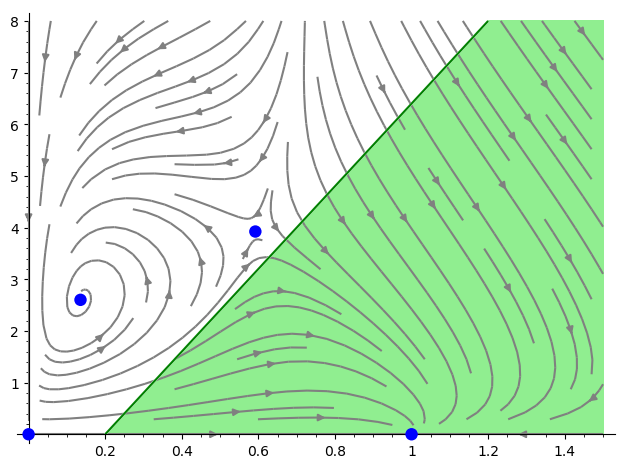

In [30]:
g = Graphics()
g += streamline_plot(tuple(vf),(x,0,1.5),(y,0,8),color="grey")
g += region_plot([SR(x) >= (1/8)*SR(y)+0.2], (x,0,1.5),(y,0,8),
                 incol="lightgreen", bordercol="green")
g += points(equillib,color="blue",size=80,zorder=100)
g.show(aspect_ratio="automatic")

In [31]:
lzz(vf, [[('GEQ', x), ('GEQ', y)]], [[('LEQ', (1/8)*y+QQ(1/5) - x)]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*x^2*y + 3/5*x^2 + 6/25*x*y - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*x^2*y - 8/5*x*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = -x + 1/8*y + 1/5
---
I     = <-x + 1/8*y + 1/5>
basis = <x - 1/8*y - 1/5>
L[2]  = -11/20*x^2*y + 3/5*x^2 + 11/25*x*y - 1/160*y^2 - 3/5*x - 1/160*y
---
I     = <-x + 1/8*y + 1/5, -11/20*x^2*y + 3/5*x^2 + 11/25*x*y - 1/160*y^2 - 3/5*x - 1/160*y>
basis = <y^3 - 196/55*y^2 - 472/275*y + 3072/275, x - 1/8*y - 1/5>
L[3]  = 11/10*x^4*y - 33/100*x^3*y^2 - 37/50*x^3*y + 897/2000*x^2*y^2 - 18/25*x^3 - 81/125*x^2*y - 369/2500*x*y^2 + 1/1600*y^3 + 27/25*x^2 + 47/125*x*y + 3/3200*y^2 - 9/25*x +

True

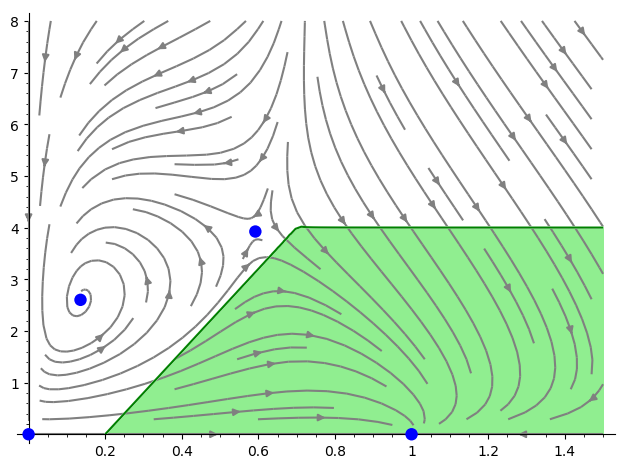

In [32]:
g = Graphics()
g += streamline_plot(tuple(vf),(x,0,1.5),(y,0,8),color="grey")
g += region_plot([SR(y) <= 4, SR(x) >= (1/8)*SR(y)+0.2], (x,0,1.5),(y,0,8),
                 incol="lightgreen", bordercol="green")
g += points(equillib,color="blue",size=80,zorder=100)
g.show(aspect_ratio="automatic")

In [33]:
lzz(vf,[[('GEQ', x), ('GEQ', y)]], [[('LEQ', y - QQ(4)), ('LEQ', QQ(1/8)*y + QQ(1/5) - x)]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*x^2*y + 3/5*x^2 + 6/25*x*y - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*x^2*y - 8/5*x*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = y - 4
---
I     = <y - 4>
basis = <y - 4>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
---
I     = <y - 4, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y>
basis = <x^2 - 4/5*x + 1/8, y - 4>
L[3]  = 4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/400*y
---
I     = <y - 4, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y, 4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/40

True

### Should be false

In [34]:
g = Graphics()
g += streamline_plot(tuple(vf),(x,0,1.5),(y,0,8),color="grey")
g += region_plot([SR(y) <= QQ(4), SR(x) >= (1/8)*SR(y)+0.1], (x,0,1.5),(y,0,8),
                 incol="lightgreen", bordercol="green")
g += points(equillib,color="blue",size=80,zorder=100)
g.show(aspect_ratio="automatic")

In [35]:
lzz(vf,[[('GEQ', x), ('GEQ', y)]], [[('LEQ', y - 4), ('LEQ', QQ(1/8)*y + QQ(1/10) - x)]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*x^2*y + 3/5*x^2 + 6/25*x*y - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*x^2*y - 8/5*x*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = y - 4
---
I     = <y - 4>
basis = <y - 4>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
---
I     = <y - 4, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y>
basis = <x^2 - 4/5*x + 1/8, y - 4>
L[3]  = 4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/400*y
---
I     = <y - 4, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y, 4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/40

False

### Ellipsoid region

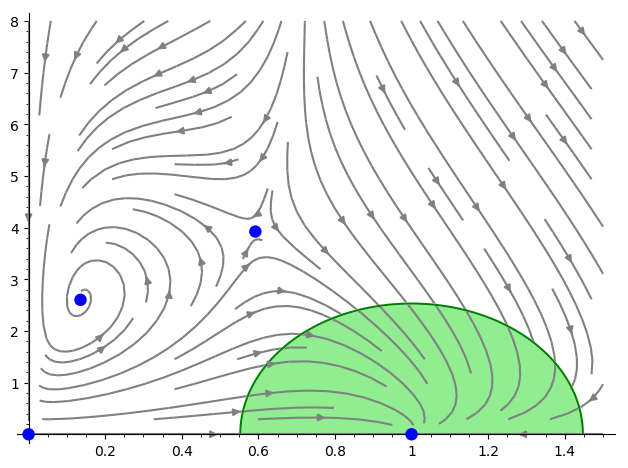

In [36]:
g = Graphics()
g += streamline_plot(tuple(vf),(x,0,1.5),(y,0,8),color="grey")
g += region_plot([0.2 >= (SR(x) - 1)**2 + QQ(1/32)*SR(y)**2], (x,0,1.5),(y,0,8),
                 incol="lightgreen", bordercol="green")
g += points(equillib,color="blue",size=80,zorder=100)
g.show(aspect_ratio="automatic")

In [37]:
lzz(vf, [[('GEQ', x), ('GEQ', y)]], [[('GEQ', QQ(0.2) - (x - 1)**2 - QQ(1/32)*y**2)]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*x^2*y + 3/5*x^2 + 6/25*x*y - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*x^2*y - 8/5*x*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = -x^2 - 1/32*y^2 + 2*x - 4/5
---
I     = <-x^2 - 1/32*y^2 + 2*x - 4/5>
basis = <x^2 + 1/32*y^2 - 2*x + 4/5>
L[2]  = -3/5*x^3*y + 1/8*x^2*y^2 + 6/5*x^3 + 27/25*x^2*y - 1/10*x*y^2 + 1/320*y^3 - 12/5*x^2 - 12/25*x*y + 1/320*y^2 + 6/5*x
---
I     = <-x^2 - 1/32*y^2 + 2*x - 4/5, -3/5*x^3*y + 1/8*x^2*y^2 + 6/5*x^3 + 27/25*x^2*y - 1/10*x*y^2 + 1/320*y^3 - 12/5*x^2 - 12/25*x*y + 1/320*y^2 + 6/5*x>
basis = <y^5 - 370/43*y^4 + 50496/215*x*y^2 + 40356/1075*y^3 - 410112/1075*x*y - 41912/215*y^2

True

### Half plane

In [38]:
g = Graphics()
g += streamline_plot(tuple(vf),(x,0,1.5),(y,0,8),color="grey")
g += region_plot([SR(x) >= 0.2], (x,0,1.5),(y,0,8),
                 incol="lightgreen", bordercol="green")
g += points(equillib,color="blue",size=80,zorder=100)
g.show(aspect_ratio="automatic")

In [39]:
lzz(vf, [[('GEQ', x), ('GEQ', y)]], [[('GEQ', x - QQ(0.2))]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*x^2*y + 3/5*x^2 + 6/25*x*y - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*x^2*y - 8/5*x*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x - 1/5
---
I     = <x - 1/5>
basis = <x - 1/5>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
---
I     = <x - 1/5, 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x>
basis = <x - 1/5, y - 8/3>
L[3]  = -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x
---
I     = <x - 1/5, 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/

False

### Oversized ellipsoid region

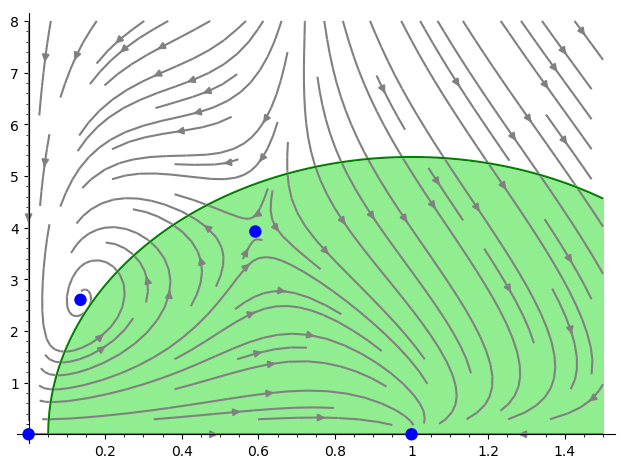

In [40]:
g = Graphics()
g += streamline_plot(tuple(vf),(x,0,1.5),(y,0,8),color="grey")
g += region_plot([0.9 >= (SR(x) - 1)**2 + QQ(1/32)*SR(y)**2], (x,0,1.5),(y,0,8),
                 incol="lightgreen", bordercol="green")
g += points(equillib,color="blue",size=80,zorder=100)
g.show(aspect_ratio="automatic")

In [41]:
lzz(vf, [[('GEQ', x), ('GEQ', y)]], [[('GEQ', QQ(0.9) - (x - QQ(1))**2 - QQ(1/32)*y**2)]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*x^2*y + 3/5*x^2 + 6/25*x*y - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*x^2*y - 8/5*x*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = -x^2 - 1/32*y^2 + 2*x - 1/10
---
I     = <-x^2 - 1/32*y^2 + 2*x - 1/10>
basis = <x^2 + 1/32*y^2 - 2*x + 1/10>
L[2]  = -3/5*x^3*y + 1/8*x^2*y^2 + 6/5*x^3 + 27/25*x^2*y - 1/10*x*y^2 + 1/320*y^3 - 12/5*x^2 - 12/25*x*y + 1/320*y^2 + 6/5*x
---
I     = <-x^2 - 1/32*y^2 + 2*x - 1/10, -3/5*x^3*y + 1/8*x^2*y^2 + 6/5*x^3 + 27/25*x^2*y - 1/10*x*y^2 + 1/320*y^3 - 12/5*x^2 - 12/25*x*y + 1/320*y^2 + 6/5*x>
basis = <y^5 - 370/43*y^4 + 50496/215*x*y^2 + 6196/1075*y^3 - 1001472/1075*x*y + 264/43*y^

False

## Finding algebraic invariants via template

In [42]:
R.<u1,u2,u3,u4,u5,u6,x,y> = QQ[]; R

Multivariate Polynomial Ring in u1, u2, u3, u4, u5, u6, x, y over Rational Field

In [43]:
p = u1 + u2*x + u3*y; p

u2*x + u3*y + u1

In [44]:
vff = vector([R(v) for v in vf]); vff

(3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y)

In [45]:
r = lie(vff,p).reduce(ideal(p)); r

-2*u3*x^2*y - 3/10*u3*x*y^2 - 3/10*u1*x*y + 11/5*u3*x*y + 19/100*u3*y^2 + 3/5*u1*x + 6/25*u1*y - 13/20*u3*y - 3/5*u1

In [46]:
F = qf.forall([x,y], qf.implies(qf.and_(SR(x) >= 0, SR(y) >= 0), SR(r) == 0)); F

(A x)(A y)[[x >= 0 /\ y >= 0] ==> -2 u3 x^2 y - 3/10 u3 x y^2 - 3/10 u1 x y + 11/5 u3 x y + 19/100 u3 y^2 + 3/5 u1 x + 6/25 u1 y - 13/20 u3 y - 3/5 u1 = 0]

In [47]:
qepcad(F)

u1 = 0 /\ u3 = 0

So, $0 = \alpha x$ is an invariant 

In [48]:
p = u1 + u2*x**2 + u3*y**2; p

u2*x^2 + u3*y^2 + u1

In [49]:
r = lie(vff,p).reduce(ideal(p)); r

-4*u3*x^2*y^2 - 3/5*u3*x*y^3 + 22/5*u3*x*y^2 + 19/50*u3*y^3 - 3/5*u1*x*y - 13/10*u3*y^2 + 6/5*u1*x + 12/25*u1*y - 6/5*u1

In [50]:
F = qf.forall([x,y], qf.implies(qf.and_(SR(x) >= 0, SR(y) >= 0), SR(r) == 0)); F

(A x)(A y)[[x >= 0 /\ y >= 0] ==> -4 u3 x^2 y^2 - 3/5 u3 x y^3 + 22/5 u3 x y^2 + 19/50 u3 y^3 - 3/5 u1 x y - 13/10 u3 y^2 + 6/5 u1 x + 12/25 u1 y - 6/5 u1 = 0]

In [51]:
qepcad(F)

u1 = 0 /\ u3 = 0

So, $0 = \alpha x^2$ is an invariant

Attempt to find additional invariants in restricted region:

In [52]:
F = qf.forall([x,y], qf.implies(qf.and_(SR(x) >= 0, SR(y) >= 0, (1/8)*SR(y) + QQ(1/5) - SR(x) <= 0, SR(y) <= 4), SR(r) == 0)); F

(A x)(A y)[[x >= 0 /\ y >= 0 /\ -x + 1/8 y + 1/5 <= 0 /\ y <= 4] ==> -4 u3 x^2 y^2 - 3/5 u3 x y^3 + 22/5 u3 x y^2 + 19/50 u3 y^3 - 3/5 u1 x y - 13/10 u3 y^2 + 6/5 u1 x + 12/25 u1 y - 6/5 u1 = 0]

In [74]:
def h():
    print "timeout!"

In [78]:
with timeout(1, h):
    q = qepcad(F)
q

Interrupting Qepcad...
timeout!


u1 = 0 /\ u3 = 0

Better to solve for coefficients using builtin solver

In [54]:
S = QQ['u1,u2,u3,u4,u5,u6']['x,y']; S

Multivariate Polynomial Ring in x, y over Multivariate Polynomial Ring in u1, u2, u3, u4, u5, u6 over Rational Field

In [55]:
coeffs = S(r).coefficients(); coeffs

[-4*u3,
 -3/5*u3,
 22/5*u3,
 19/50*u3,
 -3/5*u1,
 -13/10*u3,
 6/5*u1,
 12/25*u1,
 -6/5*u1]

In [56]:
solve(map(SR, coeffs), map(SR, [u1,u2,u3,u4,u5,u6]))

[[u1 == 0, u2 == r4, u3 == 0, u4 == r3, u5 == r2, u6 == r1]]

### Full template

In [57]:
S.<u1,u2,u3,u4,u5,u6,x,y> = QQ[]; S

Multivariate Polynomial Ring in u1, u2, u3, u4, u5, u6, x, y over Rational Field

In [58]:
vff = vector([S(v) for v in vf]); vff

(3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y)

In [59]:
p = u1 + u2*x + u3*y + u4*x*y + u5*x**2 + u6*y**2; p

u5*x^2 + u4*x*y + u6*y^2 + u2*x + u3*y + u1

In [60]:
vff[0]

3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x

In [61]:
r = lie(vff, p) % p; r

4*u5*x^4 + 2*u4*x^3*y + 3/5*u5*x^3*y + 3/10*u4*x^2*y^2 + 4*u2*x^3 - 22/5*u5*x^3 + 3/10*u2*x^2*y + 2*u3*x^2*y - 11/5*u4*x^2*y - 19/50*u5*x^2*y - 19/100*u4*x*y^2 + 4*u1*x^2 - 19/5*u2*x^2 + 13/10*u5*x^2 - 7/50*u2*x*y - 8/5*u3*x*y + 13/20*u4*x*y + 1/20*u3*y^2 - 16/5*u1*x + 7/10*u2*x + 1/10*u1*y + 1/20*u3*y + 1/10*u1

In [62]:
F = qf.forall([x,y], SR(r) == 0); F

(A x)(A y)[4 u5 x^4 + 2 u4 x^3 y + 3/5 u5 x^3 y + 3/10 u4 x^2 y^2 + 4 u2 x^3 - 22/5 u5 x^3 + 3/10 u2 x^2 y + 2 u3 x^2 y - 11/5 u4 x^2 y - 19/50 u5 x^2 y - 19/100 u4 x y^2 + 4 u1 x^2 - 19/5 u2 x^2 + 13/10 u5 x^2 - 7/50 u2 x y - 8/5 u3 x y + 13/20 u4 x y + 1/20 u3 y^2 - 16/5 u1 x + 7/10 u2 x + 1/10 u1 y + 1/20 u3 y + 1/10 u1 = 0]

In [63]:
# qepcad(F) # too slow!

Better to solve for coefficients using builtin solver

In [64]:
S = QQ['u1,u2,u3,u4,u5,u6']['x,y']; S

Multivariate Polynomial Ring in x, y over Multivariate Polynomial Ring in u1, u2, u3, u4, u5, u6 over Rational Field

In [65]:
coeffs = S(r).coefficients(); coeffs

[4*u5,
 2*u4 + 3/5*u5,
 3/10*u4,
 4*u2 - 22/5*u5,
 3/10*u2 + 2*u3 - 11/5*u4 - 19/50*u5,
 -19/100*u4,
 4*u1 - 19/5*u2 + 13/10*u5,
 -7/50*u2 - 8/5*u3 + 13/20*u4,
 1/20*u3,
 -16/5*u1 + 7/10*u2,
 1/10*u1 + 1/20*u3,
 1/10*u1]

In [66]:
solve(map(SR, coeffs), map(SR, [u1,u2,u3,u4,u5,u6]))

[[u1 == 0, u2 == 0, u3 == 0, u4 == 0, u5 == 0, u6 == r5]]

### Search using general template

In [67]:
n = 2

In [68]:
us = ['u{}{}'.format(i,j) for i in range(n) for j in range(n)]; us

['u00', 'u01', 'u10', 'u11']

In [69]:
R = PolynomialRing(QQ, ','.join(us + ['x','y']), order='degrevlex'); R

Multivariate Polynomial Ring in u00, u01, u10, u11, x, y over Rational Field

In [70]:
S = QQ[','.join(us)]['x','y']; S

Multivariate Polynomial Ring in x, y over Multivariate Polynomial Ring in u00, u01, u10, u11 over Rational Field

In [71]:
uus = R.gens()[:-2]; uus

(u00, u01, u10, u11)

In [72]:
x,y = R.gens()[-2:]

In [73]:
vs = [R(x^i*y^j) for i in range(n) for j in range(n)]; vs

[1, y, x, x*y]

In [74]:
vff = vector([R(v) for v in vf]); vff

(3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y)

In [75]:
templ = sum(u * v for u, v in zip(uus,vs)); templ

u11*x*y + u10*x + u01*y + u00

In [76]:
r = lie(vff, templ) % templ; r

2*u10*x^3 - 3/10*u01*x*y^2 + 2*u00*x^2 - 8/5*u10*x^2 - 3/10*u00*x*y + 3/5*u01*x*y + 1/20*u10*x*y + 6/25*u01*y^2 - u00*x + 1/20*u10*x + 29/100*u00*y - 3/5*u01*y - 11/20*u00

In [77]:
#r = lie(vff, templ).reduce(ideal([templ])); r

In [78]:
coeffs = S(r).coefficients(); coeffs

[2*u10,
 -3/10*u01,
 2*u00 - 8/5*u10,
 -3/10*u00 + 3/5*u01 + 1/20*u10,
 6/25*u01,
 -u00 + 1/20*u10,
 29/100*u00 - 3/5*u01,
 -11/20*u00]

In [79]:
sln = solve(map(SR, coeffs), map(SR, uus)); sln

[[u00 == 0, u01 == 0, u10 == 0, u11 == r6]]

In [80]:
zs = [eq.lhs() for eq in sln[0] if eq.rhs() == 0]; zs

[u00, u01, u10]

In [81]:
templ.subs(**{str(z):0 for z in zs})

u11*x*y

So apparently $x^ny^n = 0$ is an invariant

In [82]:
g = Graphics()
g += streamline_plot(map(SR, tuple(vf)), (x,0,1.5), (y,0,8),
                     color="grey")
g += implicit_plot(SR(x^3*y^3) == 0,
                   (x,0,1.5), (y,0,8), color="blue")
#g += points((4,2), size=100, color="red", zorder=10)
g.show(aspect_ratio='automatic')

So: bad example, we cannot find any invariant curves apart from the axes!

## Formula parameter synthesis

We first try to synthesis the range of parameters $m$ such that $x \geq \frac{1}{32} y + m$ is a continuous invariant.

In [83]:
R.<m,x,y> = QQ[]; R

Multivariate Polynomial Ring in m, x, y over Rational Field

In [84]:
m = R.gens_dict()['m']; m

m

### Elliptical region

In [85]:
s = m - (x - 1)**2 - QQ(1/32)*y**2; s

-x^2 - 1/32*y^2 + m + 2*x - 1

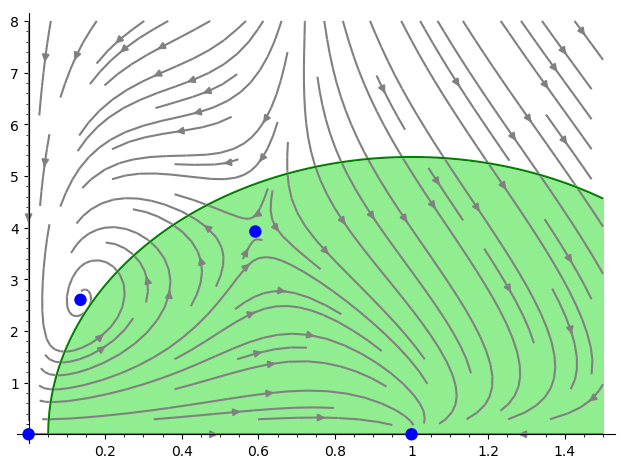

In [86]:
g = Graphics()
g += streamline_plot(tuple(vf),(x,0,1.5),(y,0,8),color="grey")
g += region_plot([0 <= SR(s.subs(m=0.9))], (x,0,1.5),(y,0,8),
                 incol="lightgreen", bordercol="green")
g += points(equillib,color="blue",size=80,zorder=100)
g.show(aspect_ratio="automatic")

In [87]:
vvf = vector(map(SR, vf)); vvf

(3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y)

Should be false

In [88]:
lzz(vf, [[('GEQ', x), ('GEQ', y)]], [[('GEQ', s.subs(m=QQ(0.9)))]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*x^2*y + 3/5*x^2 + 6/25*x*y - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*x^2*y - 8/5*x*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = -x^2 - 1/32*y^2 + 2*x - 1/10
---
I     = <-x^2 - 1/32*y^2 + 2*x - 1/10>
basis = <x^2 + 1/32*y^2 - 2*x + 1/10>
L[2]  = -3/5*x^3*y + 1/8*x^2*y^2 + 6/5*x^3 + 27/25*x^2*y - 1/10*x*y^2 + 1/320*y^3 - 12/5*x^2 - 12/25*x*y + 1/320*y^2 + 6/5*x
---
I     = <-x^2 - 1/32*y^2 + 2*x - 1/10, -3/5*x^3*y + 1/8*x^2*y^2 + 6/5*x^3 + 27/25*x^2*y - 1/10*x*y^2 + 1/320*y^3 - 12/5*x^2 - 12/25*x*y + 1/320*y^2 + 6/5*x>
basis = <y^5 - 370/43*y^4 + 50496/215*x*y^2 + 6196/1075*y^3 - 1001472/1075*x*y + 264/43*y^

False

Attempt parameter synthesis -- too slow

In [89]:
# lzz(vf, [[('GEQ', x), ('GEQ', y)]], [[('GEQ', s)]])

In [90]:
print lzz_mathematica(vf, [[('GEQ', x), ('GEQ', y)]], [[('GEQ', s)]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*x^2*y + 3/5*x^2 + 6/25*x*y - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*x^2*y - 8/5*x*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = -x^2 - 1/32*y^2 + m + 2*x - 1
---
I     = <-x^2 - 1/32*y^2 + m + 2*x - 1>
basis = <x^2 + 1/32*y^2 - m - 2*x + 1>
L[2]  = -3/5*x^3*y + 1/8*x^2*y^2 + 6/5*x^3 + 27/25*x^2*y - 1/10*x*y^2 + 1/320*y^3 - 12/5*x^2 - 12/25*x*y + 1/320*y^2 + 6/5*x
---
I     = <-x^2 - 1/32*y^2 + m + 2*x - 1, -3/5*x^3*y + 1/8*x^2*y^2 + 6/5*x^3 + 27/25*x^2*y - 1/10*x*y^2 + 1/320*y^3 - 12/5*x^2 - 12/25*x*y + 1/320*y^2 + 6/5*x>
basis = <y^5 - 1952/43*m*y^3 - 370/43*y^4 + 18432/43*m^2*y - 33792/43*m*x*y + 12352/43

Too slow for mathematica also!

### Half-plane

In [91]:
s = x - m; s

-m + x

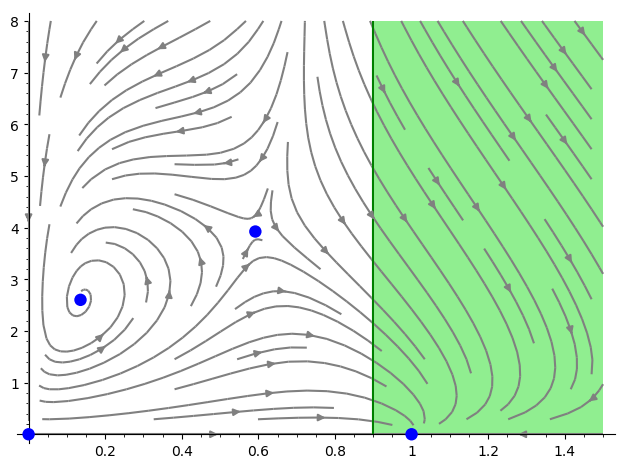

In [92]:
g = Graphics()
g += streamline_plot(tuple(vf),(x,0,1.5),(y,0,8),color="grey")
g += region_plot([0 <= SR(s.subs(m=0.9))], (x,0,1.5),(y,0,8),
                 incol="lightgreen", bordercol="green")
g += points(equillib,color="blue",size=80,zorder=100)
g.show(aspect_ratio="automatic")

In [93]:
vvf = vector(map(SR, vf)); vvf

(3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y)

Should be true

In [94]:
lzz(vf, [[('GEQ', x), ('GEQ', y)]], [[('GEQ', s.subs(m=QQ(0.9)))]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*x^2*y + 3/5*x^2 + 6/25*x*y - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*x^2*y - 8/5*x*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x - 9/10
---
I     = <x - 9/10>
basis = <x - 9/10>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
---
I     = <x - 9/10, 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x>
basis = <x - 9/10, y + 2>
L[3]  = -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x
---
I     = <x - 9/10, 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y +

True

Should be false

In [95]:
lzz(vf, [[('GEQ', x), ('GEQ', y)]], [[('GEQ', s.subs(m=QQ(0.1)))]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*x^2*y + 3/5*x^2 + 6/25*x*y - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*x^2*y - 8/5*x*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x - 1/10
---
I     = <x - 1/10>
basis = <x - 1/10>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
---
I     = <x - 1/10, 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x>
basis = <x - 1/10, y - 18/7>
L[3]  = -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x
---
I     = <x - 1/10, 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*

False

Attempt parameter synthesis -- it works!

In [96]:
lzz(vf, [[('GEQ', x), ('GEQ', y)]], [[('GEQ', s)]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*x^2*y + 3/5*x^2 + 6/25*x*y - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*x^2*y - 8/5*x*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = -m + x
---
I     = <-m + x>
basis = <m - x>
L[2]  = 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x
---
I     = <-m + x, 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x>
basis = <x^2*y - 2*x^2 - 4/5*x*y + 2*x, m - x>
L[3]  = -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x
---
I     = <-m + x, 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/10

m - 1 <= 0 /\ [ 5 m - 4 >= 0 \/ m <= 0 ]

## Model parameter synthesis

In [97]:
try: del k
except: pass

In [98]:
R.<k, x,y> = QQ[]
us = [x,y]
b=QQ(0.6); c=QQ(0.3); e=QQ(0.05); f=QQ(2)
vf = vector([b*x*(QQ(1)-x) - c*x*(k-x)*y,
            -e*y*(QQ(1)+y)+f*x*(k-x)*y])
v0 = [2.0, 1.0]

In [99]:
tuple(map(SR,vf.subs(k=1/3)))

(3/10*x^2*y - 3/5*x^2 - 1/10*x*y + 3/5*x,
 -2*x^2*y + 2/3*x*y - 1/20*y^2 - 1/20*y)

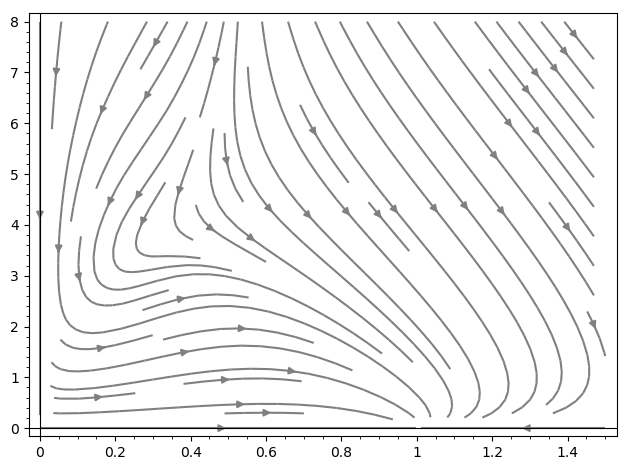

In [100]:
g = Graphics()
g += streamline_plot(tuple(map(SR,vf.subs(k=2/3))),(x,0,1.5),(y,0,8),color="grey")
#g += region_plot([0 <= SR(x - 1/3)], (x,0,1.5),(y,0,8),
#                 incol="lightgreen", bordercol="green")
g.show(aspect_ratio="automatic")

In [101]:
lzz(vf, [[('GEQ', x), ('GEQ', y)]], [[('GEQ', x - QQ(2/3))]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*k*x*y - 2*x^2*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*k*x*y - 3/10*x^2*y + 3/5*x^2 - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*k*x*y + 2*x^2*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x - 2/3
---
I     = <x - 2/3>
basis = <x - 2/3>
L[2]  = -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x
---
I     = <x - 2/3, -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x>
basis = <k*y - 2/3*y - 2/3, x - 2/3>
L[3]  = -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x
---
I     = <x - 2/3, -3/10*k*x*y + 3/10*x^2*y - 3/5*x^

3 k - 2 <= 0

In [102]:
print lzz_mathematica(vf, [[('GEQ', x), ('GEQ', y)]], [[('GEQ', x - QQ(2/3))]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*k*x*y - 2*x^2*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*k*x*y - 3/10*x^2*y + 3/5*x^2 - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*k*x*y + 2*x^2*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x - 2/3
---
I     = <x - 2/3>
basis = <x - 2/3>
L[2]  = -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x
---
I     = <x - 2/3, -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x>
basis = <k*y - 2/3*y - 2/3, x - 2/3>
L[3]  = -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x
---
I     = <x - 2/3, -3/10*k*x*y + 3/10*x^2*y - 3/5*x^

Mathematica gives the same answer

In [103]:
lzz(vf, [[('GEQ', x), ('GEQ', y)]], [[('GEQ', y-QQ(1/2))]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*k*x*y - 2*x^2*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*k*x*y - 3/10*x^2*y + 3/5*x^2 - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*k*x*y + 2*x^2*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = y - 1/2
---
I     = <y - 1/2>
basis = <y - 1/2>
L[2]  = 2*k*x*y - 2*x^2*y - 1/20*y^2 - 1/20*y
---
I     = <y - 1/2, 2*k*x*y - 2*x^2*y - 1/20*y^2 - 1/20*y>
basis = <k*x - x^2 - 3/80, y - 1/2>
L[3]  = 4*k^2*x^2*y - 8*k*x^3*y + 4*x^4*y - 3/5*k^2*x*y^2 + 9/5*k*x^2*y^2 - 6/5*x^3*y^2 - 6/5*k*x^2*y + 12/5*x^3*y - 3/10*k*x*y^2 + 3/10*x^2*y^2 + k*x*y - 11/5*x^2*y + 1/200*y^3 + 3/400*y^2 + 1/400*y
---
I     = <y - 1/2, 2*k*x*y - 2*x^2*y - 1/20*y^2 - 1/20*y, 4*k^2*x^2*y - 8*k*x^3*y + 4*x^

finish  &

In [104]:
print lzz_mathematica(vf, [[('GEQ', x), ('GEQ', y)]], [[('GEQ', y-QQ(1/2))]])

xys = (x, y)
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = 2*k*x*y - 2*x^2*y - 1/20*y^2 - 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = x
---
I     = <x>
basis = <x>
L[2]  = 3/10*k*x*y - 3/10*x^2*y + 3/5*x^2 - 3/5*x
===
===
I     = <>
basis = <0>
L[1]  = y
---
I     = <y>
basis = <y>
L[2]  = -2*k*x*y + 2*x^2*y + 1/20*y^2 + 1/20*y
===
===
I     = <>
basis = <0>
L[1]  = y - 1/2
---
I     = <y - 1/2>
basis = <y - 1/2>
L[2]  = 2*k*x*y - 2*x^2*y - 1/20*y^2 - 1/20*y
---
I     = <y - 1/2, 2*k*x*y - 2*x^2*y - 1/20*y^2 - 1/20*y>
basis = <k*x - x^2 - 3/80, y - 1/2>
L[3]  = 4*k^2*x^2*y - 8*k*x^3*y + 4*x^4*y - 3/5*k^2*x*y^2 + 9/5*k*x^2*y^2 - 6/5*x^3*y^2 - 6/5*k*x^2*y + 12/5*x^3*y - 3/10*k*x*y^2 + 3/10*x^2*y^2 + k*x*y - 11/5*x^2*y + 1/200*y^3 + 3/400*y^2 + 1/400*y
---
I     = <y - 1/2, 2*k*x*y - 2*x^2*y - 1/20*y^2 - 1/20*y, 4*k^2*x^2*y - 8*k*x^3*y + 4*x^

Mathematica's QE says false

### Parametric discrete abstraction

In [105]:
try: del k
except: pass

In [106]:
R.<k, x,y> = QQ[]
us = [x,y]
b=QQ(0.6); c=QQ(0.3); e=QQ(0.05); f=QQ(2)
vf = vector([b*x*(QQ(1)-x) - c*x*(k-x)*y,
            -e*y*(QQ(1)+y)+f*x*(k-x)*y])
v0 = [2.0, 1.0]

In [107]:
tuple(map(SR,vf.subs(k=1/3)))

(3/10*x^2*y - 3/5*x^2 - 1/10*x*y + 3/5*x,
 -2*x^2*y + 2/3*x*y - 1/20*y^2 - 1/20*y)

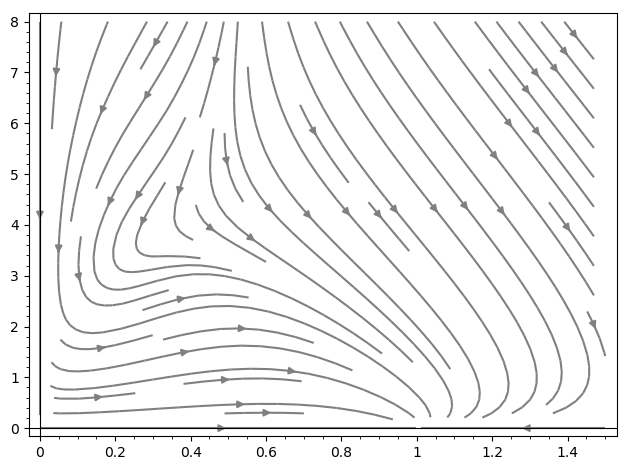

In [108]:
g = Graphics()
g += streamline_plot(tuple(map(SR,vf.subs(k=2/3))),(x,0,1.5),(y,0,8),color="grey")
#g += region_plot([0 <= SR(x - 1/3)], (x,0,1.5),(y,0,8),
#                 incol="lightgreen", bordercol="green")
g.show(aspect_ratio="automatic")

In [109]:
factsx,factsy = [[a for a,_ in v.factor() if a.variables()] for v in vf]
factsx,factsy

([x, -k*y + x*y - 2*x + 2], [y, -40*k*x + 40*x^2 + y + 1])

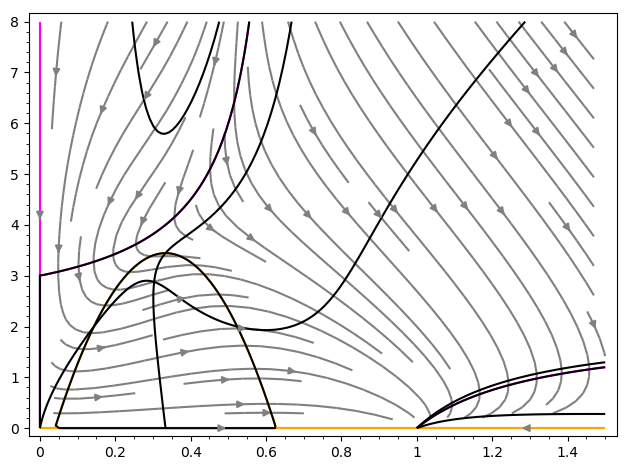

In [110]:
p = []
k0 = 2/3
p.append(streamline_plot(tuple(map(SR,vf.subs(k=k0))),
                         (x,0,1.5), (y,0,8), color="grey"))
p.append(implicit_plot(SR(factsx[0].subs(k=k0)), (x,0,1.5), (y,0,8),
                       aspect_ratio='automatic',color="magenta"))
p.append(implicit_plot(SR(factsx[1].subs(k=k0)), (x,0,1.5), (y,0,8),
                       aspect_ratio='automatic',color="magenta"))
p.append(implicit_plot(SR(factsy[0].subs(k=k0)), (x,0,1.5), (y,0,8),
                       aspect_ratio='automatic',color="orange"))
p.append(implicit_plot(SR(factsy[1].subs(k=k0)), (x,0,1.5), (y,0,8),
                       aspect_ratio='automatic',color="orange"))
for g in factsx + factsy:
    c = SR(lie(vf,g).subs(k=k0)) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color="black"))
sum(p)

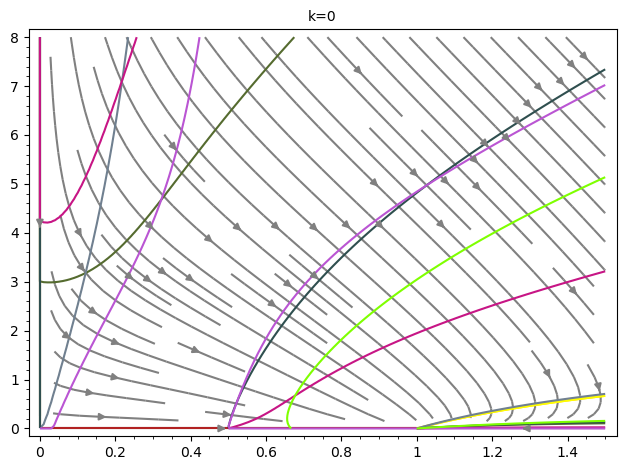

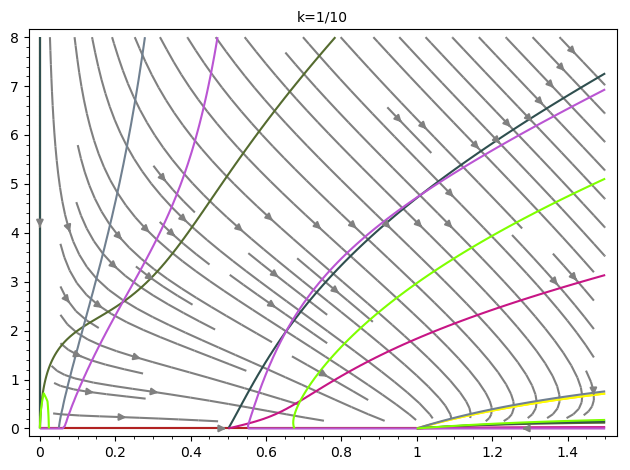

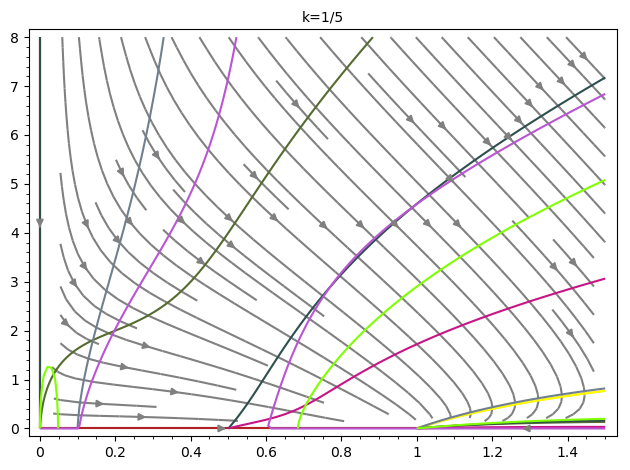

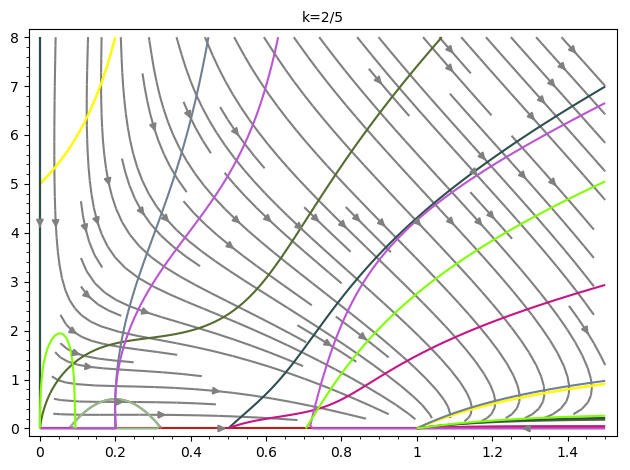

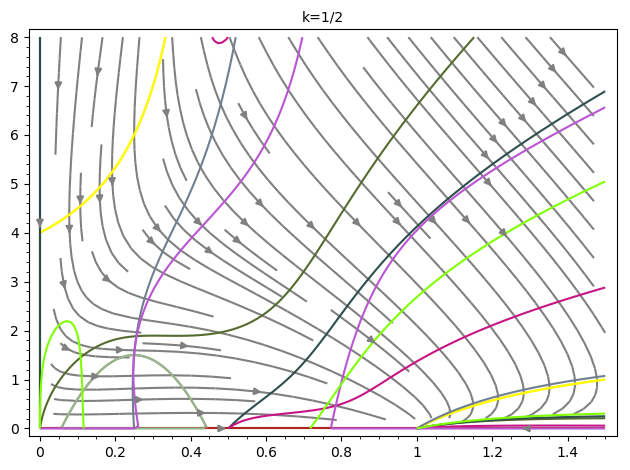

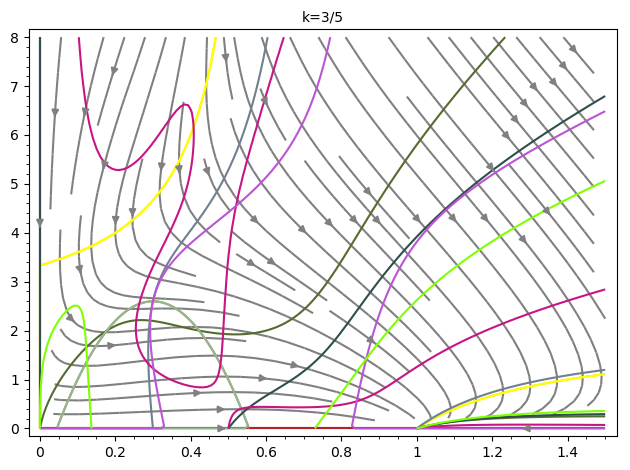

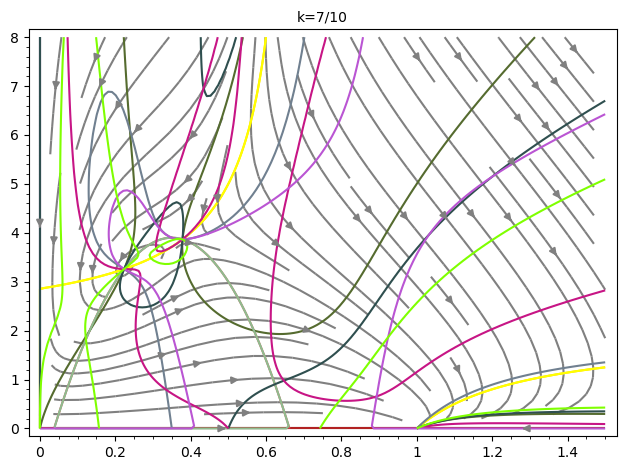

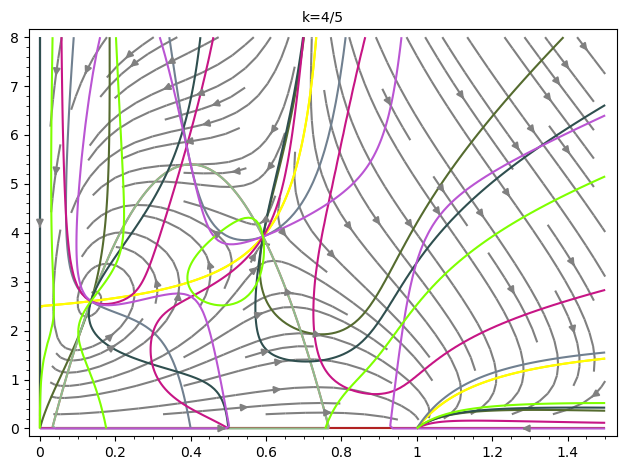

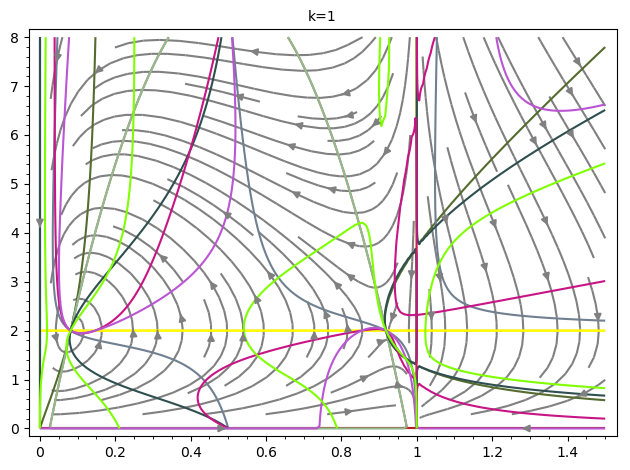

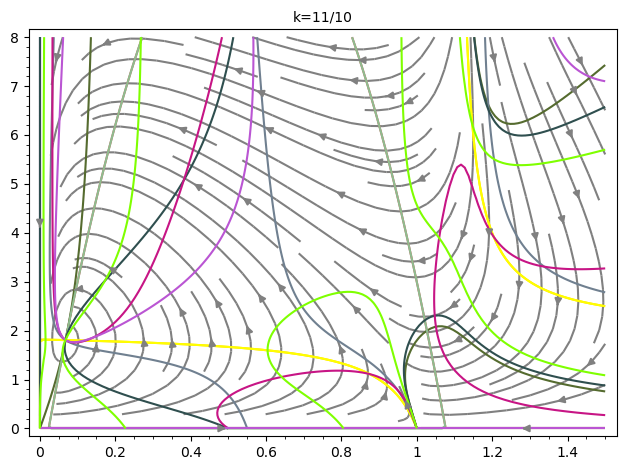

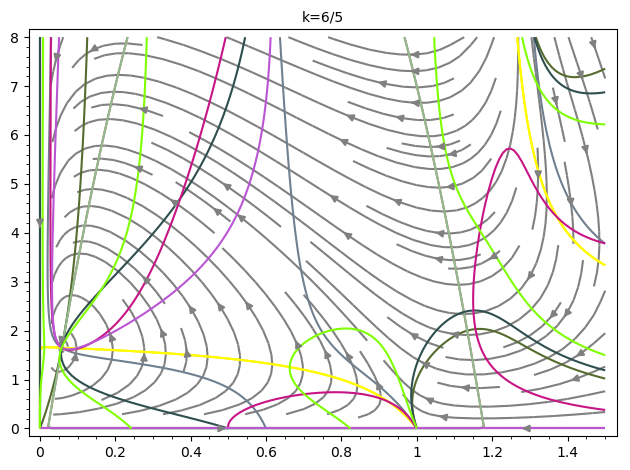

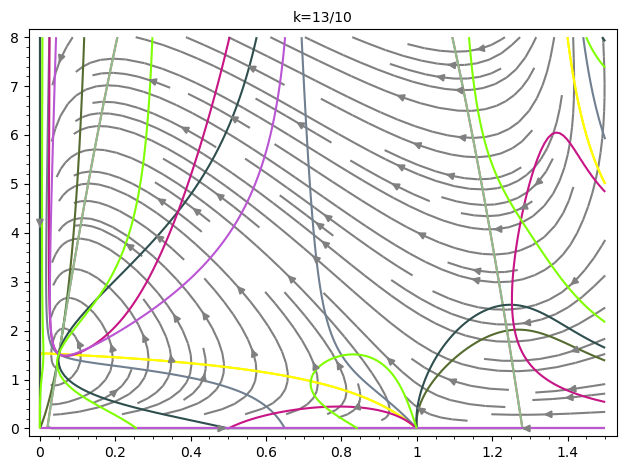

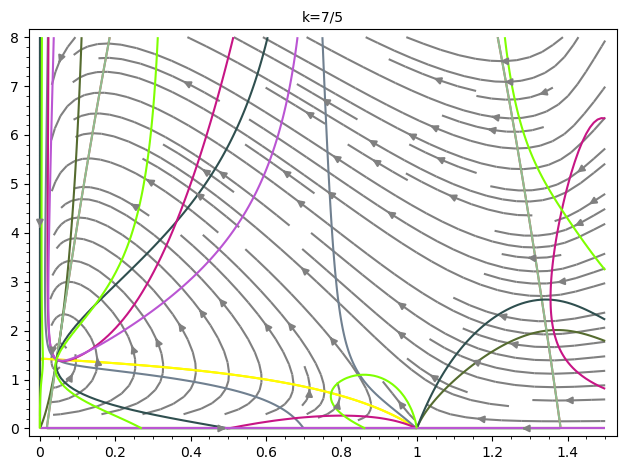

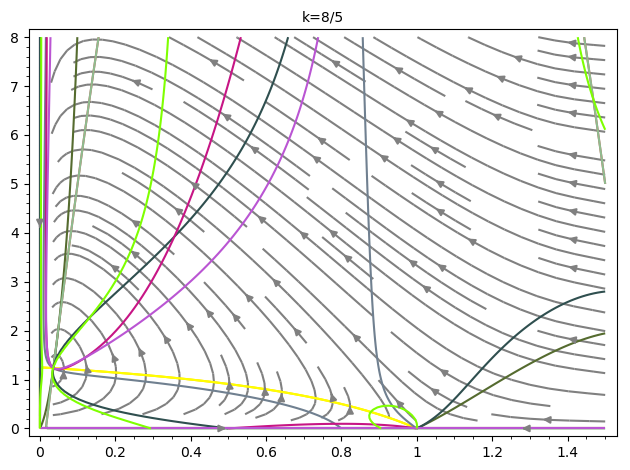

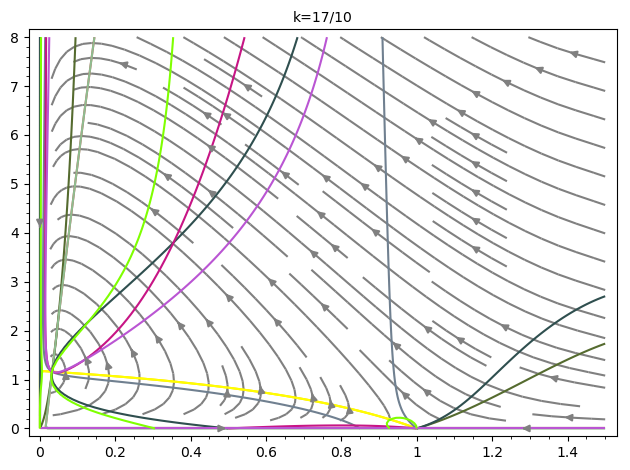

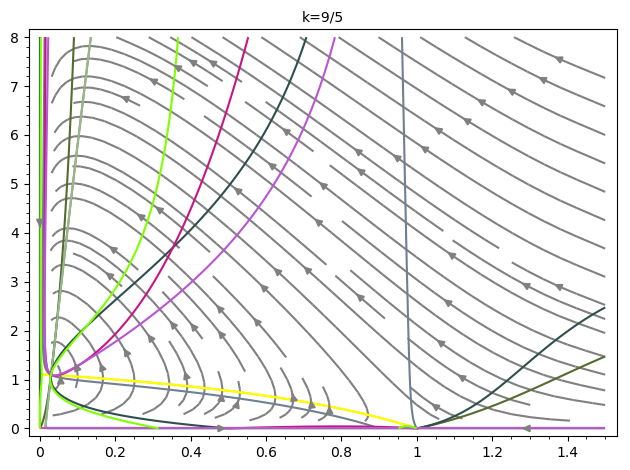

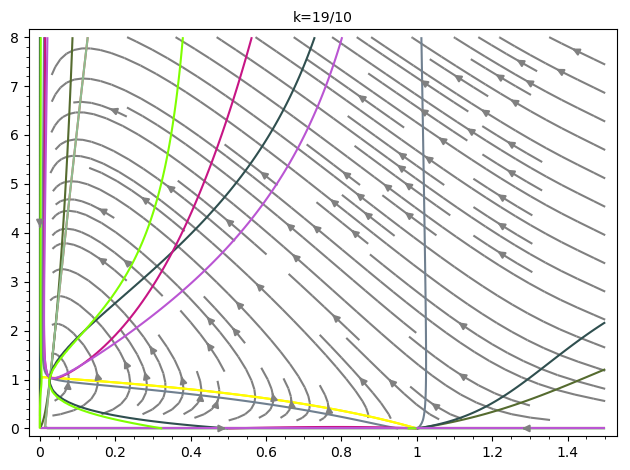

In [111]:
f0s = factsx + factsy
f1s = [lie(vf, g) for g in f0s]
f2s = [lie(vf, g) for g in f1s]
f3s = [lie(vf, g) for g in f2s]
fs = f0s + f1s + f2s
for n in range(0,21):
    k0 = QQ(n)/QQ(10)
    p = []
    p.append(streamline_plot(tuple(map(SR,vf.subs(k=k0))),
                             (x,0,1.5), (y,0,8), color="grey",
                             title="k={}".format(k0)))
    for col,l in zip(colors, fs):
        c = SR(l.subs(k=k0)) == 0
        p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                               aspect_ratio='automatic',color=col))
    show(sum(p))

In [112]:
var('t')
function("xv yv")
ODE = [diff(xv(t),t) == SR(vf[0].subs(k=k0)).subs(x=xv(t), y=yv(t)),
       diff(yv(t),t) == SR(vf[1].subs(k=k0)).subs(x=xv(t), y=yv(t))]
ODE

[diff(xv(t), t) == 3/10*xv(t)^2*yv(t) - 3/5*xv(t)^2 - 3/5*xv(t)*yv(t) + 3/5*xv(t),
 diff(yv(t), t) == -2*xv(t)^2*yv(t) + 4*xv(t)*yv(t) - 1/20*yv(t)^2 - 1/20*yv(t)]

In [113]:
#sln = desolve_system_rk4(ODE, [xv(t),yv(t)], [0, 0.2, 1]); sln

In [114]:
k0 = QQ(0.8)
vf0 = vf.subs(k=k0); vf0

(3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y)

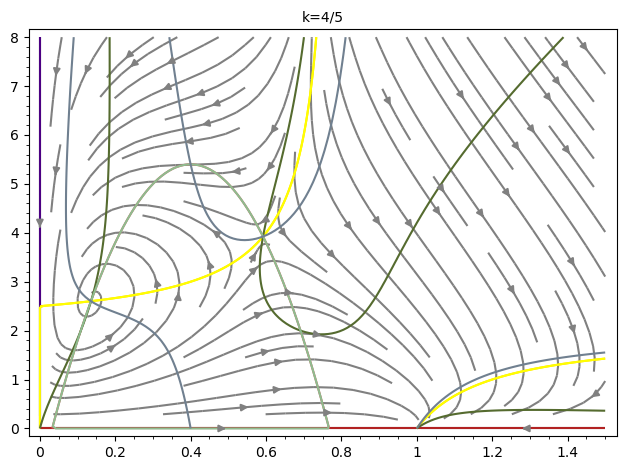

In [115]:
f0s = factsx + factsy
f1s = [lie(vf, g) for g in f0s]
f2s = [lie(vf, g) for g in f1s]
f3s = [lie(vf, g) for g in f2s]
fs = f0s + f1s
p = []
p.append(streamline_plot(tuple(map(SR,vf.subs(k=k0))),
                         (x,0,1.5), (y,0,8), color="grey",
                         title="k={}".format(k0)))
for col,l in zip(colors, fs):
    c = SR(l.subs(k=k0)) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color=col))
show(sum(p))
#plot((sln[0].rhs(),sln[1].rhs()))

### Polynomial abstraction plus grid

In [12]:
R.<x,y> = QQ[]
us = [x,y]
k=QQ(0.8); b=QQ(0.6); c=QQ(0.3); e=QQ(0.05); f=QQ(2)
vf = vector([b*x*(QQ(1)-x) - c*x*(k-x)*y,
            -e*y*(QQ(1)+y)+f*x*(k-x)*y])
v0 = [2.0, 1.0]

In [13]:
factsx,factsy = [[a for a,_ in v.factor() if a.variables()] for v in vf]
factsx,factsy

([x, 5*x*y - 10*x - 4*y + 10], [y, 40*x^2 - 32*x + y + 1])

In [14]:
f0s = factsx + factsy
f1s = [lie(vf, g) for g in f0s]
f2s = [lie(vf, g) for g in f1s]
f3s = [lie(vf, g) for g in f2s]

In [15]:
f1s

[3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x,
 -10*x^3*y + 3/2*x^2*y^2 + 10*x^2*y - 29/20*x*y^2 + 6*x^2 - 5/4*x*y + 1/5*y^2 - 6*x + 1/5*y,
 -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y,
 24*x^3*y - 48*x^3 - 154/5*x^2*y + 336/5*x^2 + 232/25*x*y - 1/20*y^2 - 96/5*x - 1/20*y]

In [16]:
f2s

[-3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x,
 20*x^5*y - 15*x^4*y^2 + 9/10*x^3*y^3 - 18*x^4*y + 45/2*x^3*y^2 - 261/200*x^2*y^3 - 37/5*x^3*y - 1719/200*x^2*y^2 + 493/1000*x*y^3 - 36/5*x^3 + 517/100*x^2*y + 111/400*x*y^2 - 1/50*y^3 + 54/5*x^2 + 429/400*x*y - 3/100*y^2 - 18/5*x - 1/100*y,
 4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/400*y,
 -48*x^5*y + 108/5*x^4*y^2 + 68/5*x^4*y - 924/25*x^3*y^2 + 432/5*x^4 + 86*x^3*y + 4827/250*x^2*y^2 - 4176/25*x^3 - 8007/125*x^2*y - 1782/625*x*y^2 + 1/200*y^3 + 2304/25*x^2 + 1204/125*x*y + 3/400*y^2 - 288/25*x + 1/400*y]

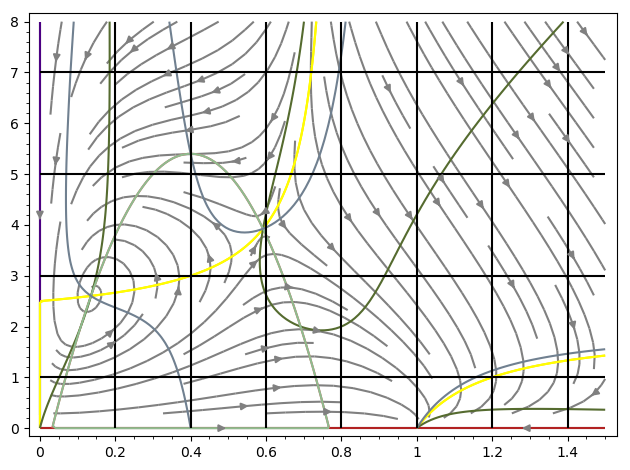

In [119]:
fs = f0s + f1s
p = []
p.append(streamline_plot(tuple(map(SR,vf)),
                         (x,0,1.5), (y,0,8), color="grey"))
# Plot polys
for col,l in zip(colors, fs):
    c = SR(l) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color=col))
# Plot grid
for s in range(1,8,2):
    c = SR(y) - SR(s) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color="black"))
for s in range(1,15,1):
    c = SR(x) - SR(s)/5 == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color="black"))
show(sum(p))

In [120]:
len(fs)

8

In [121]:
3**len(fs)

6561

In [122]:
fs = f0s + f1s + f2s
p = []
p.append(streamline_plot(tuple(map(SR,vf)),
                         (x,0,1.5), (y,0,8), color="grey"))
# Plot polys
for col,l in zip(colors, fs):
    c = SR(l) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color=col))
# Plot grid
for s in range(1,8,2):
    c = SR(y) - SR(s) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color="black"))
for s in range(1,15,1):
    c = SR(x) - SR(s)/5 == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color="black"))
p.append(text("R1", (1.3,6), fontsize="24",fontweight="bold"))
show(sum(p))

A rather large number of polynomials!

In [123]:
len(fs)

12

In [124]:
3**len(fs)

531441

However, we find only 3 intersect R1

In [127]:
R1 = [('GT', x - QQ(1.2)), ('LT', x - QQ(1.4)), ('LT', y - QQ(7)), ('GT', y - QQ(5))]; R1

[('GT', x - 6/5), ('LT', x - 7/5), ('LT', y - 7), ('GT', y - 5)]

In [128]:
R1fs = [f for f in fs if qepcad(qf.exists([x,y], from_cnf([R1 + [('EQ', f)]]))) == 'TRUE']; R1fs

[-10*x^3*y + 3/2*x^2*y^2 + 10*x^2*y - 29/20*x*y^2 + 6*x^2 - 5/4*x*y + 1/5*y^2 - 6*x + 1/5*y,
 -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x,
 4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/400*y]

How about a general grid square?

In [16]:
import signal
from subprocess import call

class TimeoutError(Exception):
    pass

class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

fs = f0s + f1s
p = []
p.append(streamline_plot(tuple(map(SR,vf)),
                         (x,0,1.5), (y,0,8), color="grey"))
# Plot polys
for col,l in zip(colors, fs):
    c = SR(l) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color=col))
# Plot grid
for n in range(1,8,2):
    y1 = QQ(n)
    y0 = y1 - 2
    p.append(implicit_plot(SR(y) - SR(y1) == 0, (x,0,1.5), (y,0,8),
                               aspect_ratio='automatic',color="black"))
    for m in range(1,8,1):
        x1 = QQ(m)/5
        x0 = x1 - QQ(1)/5
        try:
            with timeout(1):
                R = [('GT', x - x0), ('LT', x - x1), ('GT', y - y0), ('LT', y - y1)]
                Rfs = [f for f in fs if qepcad(qf.exists([x,y], from_cnf([R + [('EQ', f)]]))) == 'TRUE']
                print "{}, {}: {}".format(x0, y0, str(Rfs))
                p.append(text("{}".format(len(Rfs)), ((x1 + x0)/2,(y1 + y0)/2), fontsize="10",fontweight="bold"))
        except TimeoutError:
            print "timeout on {}, {}".format(x0,y0)
            p.append(text("?", ((x1 + x0)/2,(y1 + y0)/2), fontsize="10",fontweight="bold"))
for m in range(1,15,1):
    x0 = QQ(m)/5
    x1 = x0 + QQ(1)/5 
    p.append(implicit_plot(SR(x) - SR(x0) == 0, (x,0,1.5), (y,0,8),
                   aspect_ratio='automatic',color="black"))
show(sum(p))

Smaller grid

In [ ]:
fs = f0s + f1s
p = []
p.append(streamline_plot(tuple(map(SR,vf)),
                         (x,0,1.5), (y,0,8), color="grey"))
# Plot polys
for col,l in zip(colors, fs):
    c = SR(l) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color=col))
dy = QQ(1)
dx = QQ(1)/10
# Plot grid
for n in range(1,8,1):
    y1 = QQ(n)
    y0 = y1 - dy
    p.append(implicit_plot(SR(y) - SR(y1) == 0, (x,0,1.5), (y,0,8),
                               aspect_ratio='automatic',color="black"))
    for m in range(1,15,1):
        x1 = QQ(m)/10
        x0 = x1 - dx
        R = [('GT', x - x0), ('LT', x - x1), ('GT', y - y0), ('LT', y - y1)]
        Rfs = []
        fail = False
        for f in fs:
            started = False
            try:
                print "starting qepcad!"
                with timeout(1):
                    qc = qepcad(qf.exists([x,y], from_cnf([R + [('EQ', f)]])), interact=True)
                    started=True
            except TimeoutError:
                print "failed to start qepcad -- retrying"
                try:
                    with timeout(1):
                        qc = qepcad(qf.exists([x,y], from_cnf([R + [('EQ', f)]])), interact=True)
                        started = True
                except:
                    print "double fail to start qepcad"
                    fail = True
            if started:
                try:
                    with timeout(1):
                        qc.go()
                        qc.go()
                        qc.go()
                        ans = qc.finish()
                        if ans == 'TRUE':
                            Rfs += [f]
                        print "checked intersect"
                except TimeoutError:
                    fail = True
                    print "timeout on {}, {}: {}".format(x0,y0, f)
                    p.append(text("?", ((x1 + x0)/2,(y1 + y0)/2), fontsize="10",fontweight="bold"))
                finally:
                    qc.quit()
                    try:
                        call(["killall", "-9", "qepcad"])
                    except:
                        pass
        print "finished intersection check"
        print "{}, {}: {}".format(x0, y0, str(Rfs))
        p.append(text("{}{}".format('>= ' if fail else '', len(Rfs)), ((x1 + x0)/2,(y1 + y0)/2), fontsize="10",fontweight="bold"))
for m in range(1,15,1):
    x0 = QQ(m)/10
    x1 = x0 + dx 
    p.append(implicit_plot(SR(x) - SR(x0) == 0, (x,0,1.5), (y,0,8),
                   aspect_ratio='automatic',color="black"))
show(sum(p))

starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
finished intersection check
0, 0: [40*x^2 - 32*x + y + 1, -10*x^3*y + 3/2*x^2*y^2 + 10*x^2*y - 29/20*x*y^2 + 6*x^2 - 5/4*x*y + 1/5*y^2 - 6*x + 1/5*y, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y]
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
finished intersection check
1/10, 0: []
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
starting qepcad!
checked intersect
